# Data Cleaning

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import re
import emoji
import numpy as np
from nltk.tokenize.casual import EMOTICON_RE
#nltk.download('wordnet')
#nltk.download('words')
from nltk.sentiment.util import mark_negation
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

from collections import Counter
from wordcloud import WordCloud
from nltk import FreqDist
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


label_mapping = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
contraction_mapping = {
            "isn't": "is not",
            "aren't": "are not",
            "don't": "do not",
            "doesn't": "does not",
            "wasn't": "was not",
            "weren't": "were not",
            "didn't": "did not",
            "haven't": "have not",
            "hasn't": "has not",
            "hadn't": "had not",
            "won't": "will not",
            "can't": "cannot",
            "couldn't": "could not",
            "shouldn't": "should not",
            "wouldn't": "would not",
            "mightn't": "might not",
            "mustn't": "must not",
            }
emojis = [
    # HAPPY
    ":-)", ":)", ";)", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)",
    "=)", ":}", ":^)", ":-D", ":D", "8-D", "8D", "x-D", "xD", "X-D",
    "XD", "=-D", "=D", "=-3", "=3", ":-))", ":'-)", ":')", ":*", ":^*",
    ">:P", ":-P", ":P", "X-P", "x-p", "xp", "XP", ":-p", ":p", "=p",
    ":-b", ":b", ">:)", ">;)", ">:-)", "<3",

    # SAD
    ":L", ":-/", ">:/", ":S", ">:[", ":@", ":-(", ":[", ":-||", "=L", 
    ":<", ":-[", ":-<", "=\\", "=/", ">:(", ":(", ">.<", ":'-(", ":'(",
    ":\\", ":-c", ":c", ":{", ">:\\", ";("
]

In [2]:
script_dir = os.path.dirname(os.path.abspath('processor.ipynb'))
data_path = os.path.join(script_dir, 'Thesis_Jupyter_Final/src/')
os.getcwd()
print(data_path)

input_folder_path = os.path.join(data_path, 'input')
processed_folder_path = os.path.join(data_path, 'input/processed')
processed_normal_folder_path = os.path.join(data_path, 'input/processed/normal')
processed_neg_folder_path = os.path.join(data_path, 'input/processed/neg_tagged')

# Create the folder if it doesn't exist
if not os.path.exists(processed_normal_folder_path):
    os.makedirs(processed_normal_folder_path)

if not os.path.exists(processed_neg_folder_path):
    os.makedirs(processed_neg_folder_path)

/home2/s3985113/Thesis_Jupyter_Final/src/


Goal of project: 

This notebook includes: (steps)

# Load Data

First, we load and explore the dataset and apply some initial processing such as setting the '*Id*' column as index and removing any empty rows.

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None) 

In [4]:
def drop_missing(data):
    # Remove any rows with missing values and reset the index
    rows_before = data.shape[0] 

    data.replace('', np.nan, inplace=True)
    data = data.dropna()
    data.reset_index(drop=True, inplace=True)

    rows_after = data.shape[0]
    # Count the number of rows removed
    print(f"Number of removed rows: {rows_before - rows_after}")

    return data

In [5]:
def map_labels(label):
    if label in [1, 2]:
        return 1
    elif label == 3:
        return 2
    elif label in [4, 5]:
        return 3
    else:
        return label
    
def load_data(filename, process=True):
    # Load data
    data_file_path = os.path.join(input_folder_path, filename)
    df = pd.read_csv(data_file_path)

    # Apply the label mapping function to the 'label' column
    df['Label'] = df['Label'].map(map_labels)
    df.rename(columns={'Label': 'Sentiment'}, inplace=True)

    if process:
        # Set ID as index
        df.set_index('Id', inplace=True, drop=True)
        df = drop_missing(df)

        print(df.info())
        print()
        print(f'Dataset shape: {df.shape}\n')

    return df

data_filename = "original_data.csv"
df_original = load_data(data_filename)

Number of removed rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Review     107018 non-null  object
 1   Sentiment  107018 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
None

Dataset shape: (107018, 2)



In [6]:
df_original.head(20)

,Review,Sentiment
0,good and interesting,3
1,"This class is very helpful to me. Currently, I'm still learning this class which makes up a lot of basic music knowledge.",3
2,like!Prof and TAs are helpful and the discussion among students are quite active. Very rewarding learning experience!,3
3,Easy to follow and includes a lot basic and important techniques to use sketchup.,3
4,Really nice teacher!I could got the point eazliy but the v,3
5,"Great course - I recommend it for all, especially IT and Business Managers!",3
6,One of the most useful course on IT Management!,3
7,"I was disappointed because the name is misleading. The course provides a good introduction & overview of the responsibilities of the CTO, but has very little specifically digital content. It deals with two-speed IT in a single short lecture, so of course the treatment is superficial. It is easy to find more in-depth material freely available, on the McKinsey website for example.",2
8,Super content. I'll definitely re-do the course,3
9,One of the excellent courses at Coursera for information technology bosses and managers.,3


### Analyse Raw Data 
We then analyse the dataset by observing the distribution of review per sentiment.

Analyzing General data
3 (Positive): 97227 reviews (90.85%)
2 (Neutral): 5071 reviews (4.74%)
1 (Negative): 4720 reviews (4.41%)


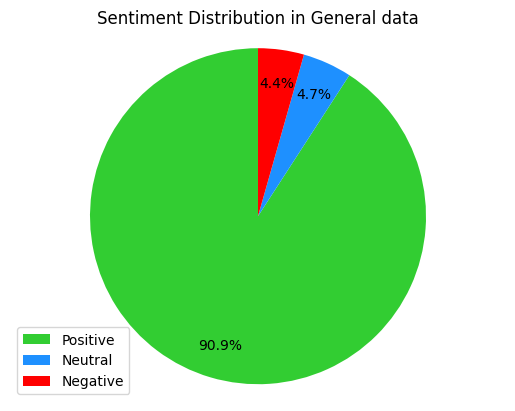

Total word count:  2661665
Average review length: 24.87



In [53]:
def print_senti_counts(counts):
     # Print the number of reviews per sentiment and their percentage
    total_count = sum(counts)
    for senti, count in counts.items():
        sentiment_name = label_mapping[senti]
        percent = (count / total_count) * 100
        print(f"{senti} ({sentiment_name}): {count} reviews ({percent:.2f}%)")


def plot_senti_counts(counts, df_type):
    # Plot counts per sentiment
    colors = ['limegreen', 'dodgerblue', 'red']
    plt.pie(counts, colors=colors, autopct='%1.1f%%',  pctdistance=0.8, textprops={'fontsize': 10, 'color': 'black'}, startangle=90)
    plt.axis('equal')  # pie as a circle
    plt.legend(labels=list(label_mapping.values())[::-1], loc='lower left')
    plt.title(f"Sentiment Distribution in {df_type} data")
    plt.show()

def count_words(text):
    # Count words per review
    return len(str(text).split(' '))

def analyse_data(df_x, df_y, df_type, plot=True):
    # Call all the data analysis functions at once
    print(f"Analyzing {df_type} data")
    
    senti_counts = df_y.value_counts()
    print_senti_counts(senti_counts)
    if plot:
        plot_senti_counts(senti_counts, df_type)

    # Calculate total and average word count without adding a new column to the dataframe
    total_word_count = df_x.apply(count_words).sum()
    avg_review_len = df_x.apply(count_words).mean()

    print("Total word count: ", total_word_count)
    print(f"Average review length: {avg_review_len:.2f}\n")


analyse_data(df_original['Review'], df_original['Sentiment'], "General")

## Clean Text

Next, we clean the data applying the following techniques (TODO: add info):

In [54]:
def clean_data(df, neg_tag=False):
    # 1) Lowercase
    df['Review'] = df['Review'].str.lower()

    # 2) Replace contractions with their standard full forms
    for contraction, standard in contraction_mapping.items():
        df['Review'] = df['Review'].str.replace(contraction, standard)

    # 3) Remove punctuation in between words e.g. "course.sometimes", "i'll" and replace with space
    pattern = r'(?<=\w)[^\w\s]+(?=\w)'
    df['Review'] = df['Review'].str.replace(pattern, ' ', regex=True)
    df['Review'] = df['Review'].str.replace(r'\.{2,}', ' ', regex=True) 

    # 4) Tokenize text into individual words (removes all extra spaces \s)
    tokenizer = TweetTokenizer()
    df['Review'] = df['Review'].apply(tokenizer.tokenize)

    # 5) Remove punctuation first in between words (typo), and then all punctuation and numerals except for tokenized emojis
    pattern = r"[^\w\s" + "".join(re.escape(e) for e in emojis + list(emoji.EMOJI_DATA.keys())) + "]|[\d]+" # match non-emoji special characters
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if not re.match(pattern, token)])

    # 6) Remove single characters
    df['Review'] = df['Review'].apply(lambda tokens: [word for word in tokens if len(word) > 1])

    # 8) Perform negation tagging
    if neg_tag:
        print("Negation-tagged")
        df['Review'] = df['Review'].apply(mark_negation)

    # 9) Remove stopwords --> also removes words like 'not'
    stop_words = set(stopwords.words('english'))
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token.split('_')[0] not in stop_words])

     # 10) Lemmatize words using WordNetLemmatizer (also lemmatizes words removing _NEG)
    def lemmatize_token(token):
        lemmatizer = WordNetLemmatizer()
        if "_NEG" in token:
            word, tag = token.split("_NEG")
            return lemmatizer.lemmatize(word) + "_NEG"
        else:
            return lemmatizer.lemmatize(token)

    df['Review'] = df['Review'].apply(lambda tokens: [lemmatize_token(token) for token in tokens])

    # Convert preprocessed tokens back to string
    df['Review'] = df['Review'].apply(' '.join)

    return df


# Create a copy of the original DataFrame to preserve the original data
df_clean = df_original.copy()
df_clean_NEG = df_original.copy()

# Apply preprocessing
df_clean = clean_data(df_clean) 
df_clean = drop_missing(df_clean) # Remove NaN rows, after cleaning text

df_clean_NEG = clean_data(df_clean_NEG, neg_tag=True) 
df_clean_NEG = drop_missing(df_clean_NEG) # Remove NaN rows, after cleaning text

print(f'Dataset shape (after text cleaning): {df_clean.shape}\n')
print(f'NEGATED Dataset shape (after text cleaning): {df_clean_NEG.shape}\n')

Number of removed rows: 31
Negation-tagged
Number of removed rows: 31
Dataset shape (after text cleaning): (106987, 2)

NEGATED Dataset shape (after text cleaning): (106987, 2)



In [55]:
df_clean.head(20)

,Review,Sentiment
0,good interesting,3
1,class helpful currently still learning class make lot basic music knowledge,3
2,like prof ta helpful discussion among student quite active rewarding learning experience,3
3,easy follow includes lot basic important technique use sketchup,3
4,really nice teacher could got point eazliy,3
5,great course recommend especially business manager,3
6,one useful course management,3
7,disappointed name misleading course provides good introduction overview responsibility cto little specifically digital content deal two speed single short lecture course treatment superficial easy find depth material freely available mckinsey website example,2
8,super content definitely course,3
9,one excellent course coursera information technology boss manager,3


In [56]:
df_clean_NEG.head(20)

,Review,Sentiment
0,good interesting,3
1,class helpful currently still learning class make lot basic music knowledge,3
2,like prof ta helpful discussion among student quite active rewarding learning experience,3
3,easy follow includes lot basic important technique use sketchup,3
4,really nice teacher could got point eazliy,3
5,great course recommend especially business manager,3
6,one useful course management,3
7,disappointed name misleading course provides good introduction overview responsibility cto little specifically digital content deal two speed single short lecture course treatment superficial easy find depth material freely available mckinsey website example,2
8,super content definitely course,3
9,one excellent course coursera information technology boss manager,3


In [58]:
clean_data_filename = "clean_data.csv"
df_clean.to_csv(os.path.join(processed_normal_folder_path, clean_data_filename), sep=',', index_label='Id')

clean_data_filename = "clean_data_NEG.csv"
df_clean_NEG.to_csv(os.path.join(processed_neg_folder_path, clean_data_filename), sep=',', index_label='Id')